In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Paths
original_dataset_dir = '/content/drive/MyDrive/Dataset'
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Categories
categories = ['benign', 'malignant']

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    category_dir = os.path.join(original_dataset_dir, category)
    images = os.listdir(category_dir)
    random.shuffle(images)

    # Split the images into 80% training and 20% validation
    train_split = int(0.8 * len(images))
    train_images = images[:train_split]
    val_images = images[train_split:]

    for image in train_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(train_dir, category, image)
        shutil.copyfile(src, dst)

    for image in val_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(val_dir, category, image)
        shutil.copyfile(src, dst)

print("Dataset restructured successfully.")

Dataset restructured successfully.


Hybrid Model

In [3]:
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.6 MB/s eta 0:00:00


In [4]:
!pip install tensorflow-addons
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [5]:
import tensorflow_addons as tfa
from vit_keras import vit

print("tensorflow-addons and vit-keras installed successfully.")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


tensorflow-addons and vit-keras installed successfully.


Found 8000 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.
347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.6761
Epoch 1: val_accuracy improved from -inf to 0.69153, saving model to /content/drive/MyDrive/Project/best_hybrid_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 447s 2s/step - loss: 0.5842 - accuracy: 0.6761 - val_loss: 0.5277 - val_accuracy: 0.6915 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.7072
Epoch 2: val_accuracy improved from 0.69153 to 0.74698, saving model to /content/drive/MyDrive/Project/best_hybrid_model.h5
250/250 [==============================] - 397s 2s/step - loss: 0.5330 - accuracy: 0.7072 - val_loss: 0.4908 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.7279
Epoch 3: val_accuracy did not improve from 0.74698
250/250 [==============================] - 362s 1s/step - loss: 0.5046 - accuracy: 0.7279 - val_loss: 0.4731 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.7423
Epoch 4: val_accuracy did not improve from 0.74698
250/250 [==============================] - 361s 1s/

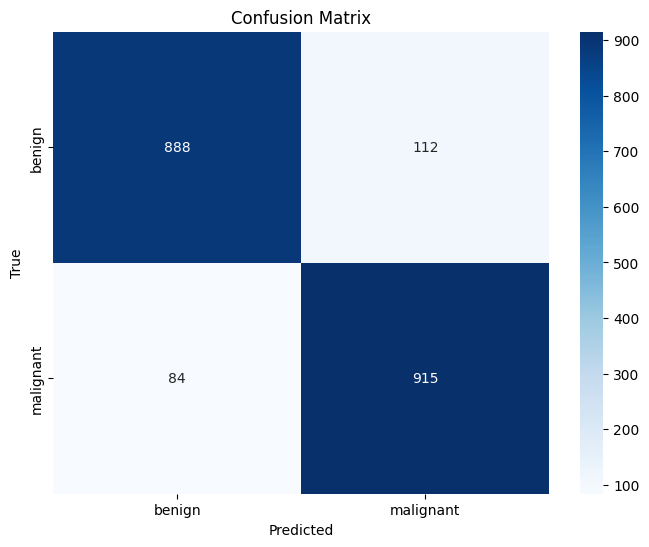

              precision    recall  f1-score   support

      benign       0.91      0.89      0.90      1000
   malignant       0.89      0.92      0.90       999

    accuracy                           0.90      1999
   macro avg       0.90      0.90      0.90      1999
weighted avg       0.90      0.90      0.90      1999



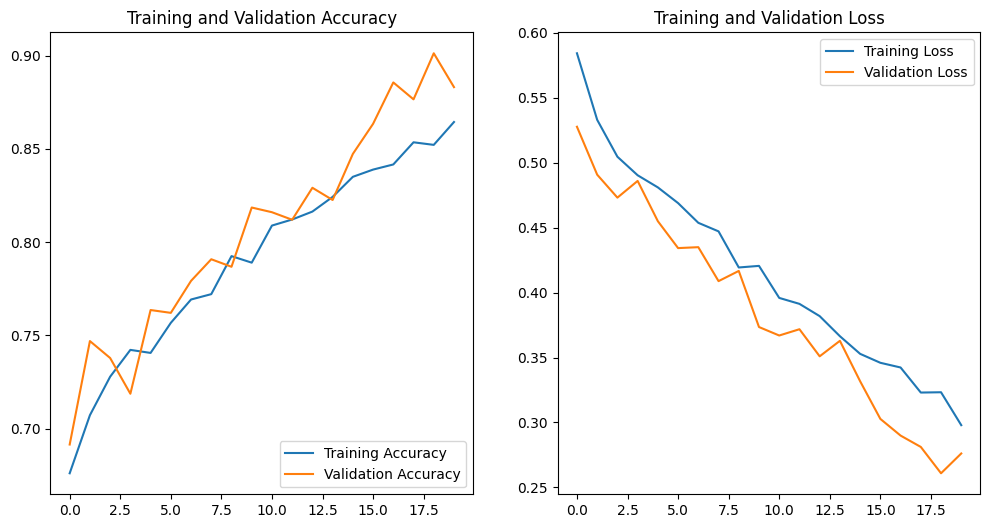

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow as tf
import tensorflow_addons as tfa

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation data should only be rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',  # Convert grayscale images to RGB
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/content/dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',  # Convert grayscale images to RGB
    shuffle=False
)

# CNN Model for local feature extraction
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return Model(inputs, x)

cnn_model = create_cnn_model((224, 224, 3))

# Vision Transformer (ViT) model
vit_model = vit.vit_b16(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

# Combine CNN and ViT
combined_input = cnn_model.input
combined_output = cnn_model.output
vit_output = vit_model(combined_input)

# Concatenate the outputs of CNN and ViT
x = tf.keras.layers.Concatenate()([combined_output, vit_output])
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1, activation='sigmoid')(x)

# Create the hybrid model
model = Model(inputs=combined_input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "/content/drive/MyDrive/Project/best_hybrid_model.h5"
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1, save_format='h5')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# Evaluate the model
accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy}")

# Load the best model
best_model = tf.keras.models.load_model(checkpoint_path)

# Save the best model explicitly
best_model.save('/content/drive/MyDrive/Project/best_hybrid_model_final.h5')

# Predict on the validation set
validation_generator.reset()
y_pred = best_model.predict(validation_generator)
y_pred = np.round(y_pred).astype(int).flatten()
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['benign', 'malignant']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
